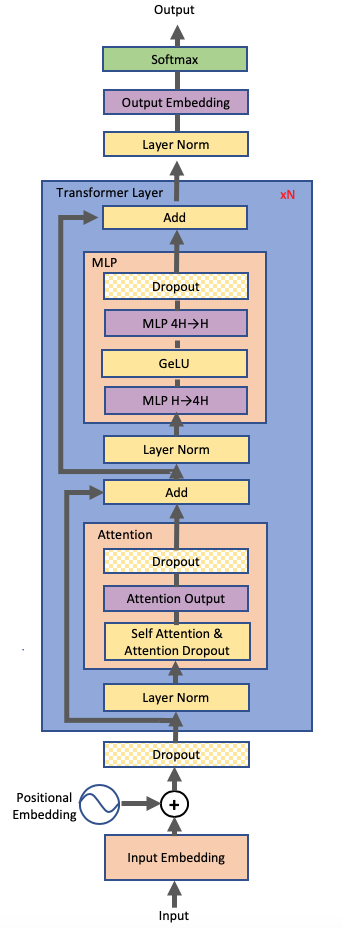

1. text를 tokenization 해줌 <br>
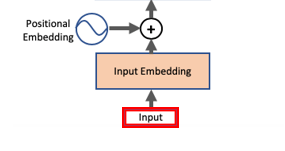

- GPT의 Pre-Training은 Unsupervised learning이기 때문에 input과 label이 유사 <br>
- GPT에는 window_size라는 변수가 있는데 이는 한 input의 토큰 갯수를 의미<br>
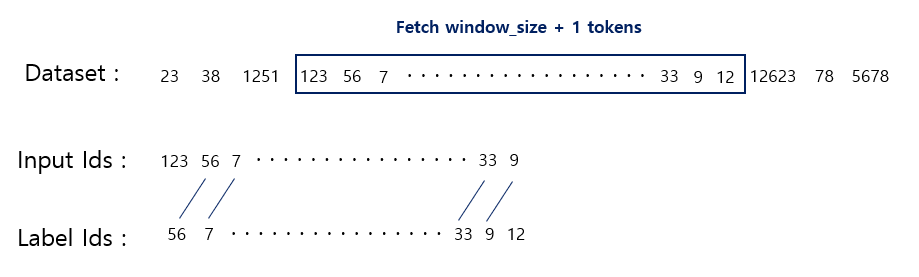<br>

In [ ]:
import h5py
import random
from torch.utils.data import Dataset
 
 
class GPTDataset(Dataset):
    def __init__(self, dataset_path: str, seq_len: int, window_size: int, rng: random.Random):
        self.dataset = h5py.File(dataset_path, 'r')['token_ids']
        self.seq_len = seq_len
        self.window_size = window_size
        self.rng = rng
        self.size = len(self.dataset)
 
    def __len__(self):
        return self.size
 
    def __getitem__(self, idx):
        start_point = self.rng.randint(0, self.size) # 0부터 self.size까지 중 랜덤
        end_point = min(start_point + (window_size + 1), self.size) # 최소 start_point에서 window_size+1만큼 더한거부터 self.size까지
        window = self.dataset[start_point: end_point]  # Windowing
 
        input_ids = window[:-1]
        label_ids = window[1:]
        return input_ids, label_ids

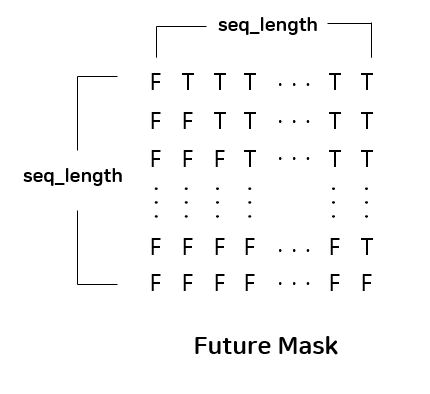

### getitem 함수
- start_point : 0 ~ 데이터셋 길이 사이의 임의의 시작점을 고른다.
- end_point : 한 sample의 끝점을 고른다.
- window : window size + 1개의 연속된 토큰을 슬라이싱한다.
- input_ids : 첫 번째 토큰부터 window_size개 = Input Ids
- label_ids : 두 번째 토큰부터 window_size개 = Label Ids

모델에 실제로 input으로 들어가게 되는 input ids와 label ids는 (batchsize, seq_length)의 shape을 가짐<br>
모델에는 input ids가 들어가고 출력된 logits과 label ids와 비교하게 된다.<br>
seq_length는 window_size와 동일 

In [ ]:
import torch

def create_future_mask(x: torch.Tensor, offset: int = 0) -> torch.Tensor:
 
    seq_len = x.size(-1)  # seq_length
 
    future = torch.ones((seq_len, seq_len), dtype=torch.bool, device=x.device)
    future = future.triu(1)
 
    future_mask = future.view((1,) * (x.ndim - 1) + future.size())
    
    return future_mask.expand(x.shape + future_mask.shape[-1:])  # (b, s, s)

2. Embedding, Dropout <br>
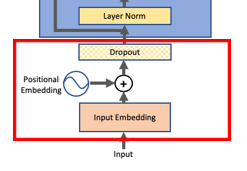

- Token Embedding(token들의 차원을 축소하는 과정) : Token Id의 차원은 vocab 개수 <br>
Vocab이 N개이면 Token Id는 0 ~ N-1의 정수가 될 수 있다. <br>
즉, 0 ~ N-1의 정수를 hidden_size의 벡터로 바꾸는 과정 <br>
hidden_size는 Embedding 차원이며 Token Embedding을 거치면 input ids(token id의 배열)이 (batch_size, seq_length, hidden_size)의 shape을 가지게 됨
- Position Embedding : GPT의 input에는 해당 token의 위치가 어디인지에 대한 정보가 없기에 postion embedding으로 위치 정보를 추가해줌 <br>
position embedding 후에도 (batch_size, seq_length, hidden_size)의 shape의 벡터를 얻음
- Dropout : Dropout 과정을 거쳐 Masked Attention Layer에 들어갈 input을 만든다.

In [ ]:
import torch.nn as nn

token_embeddings = nn.Embedding(vocab_size, hidden_size)
position_embeddings = nn.Embedding(seq_len, hidden_size)

def position_embed(input_ids, position_embeddings):

    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype = torch.long, device = input_ids.device)
    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

    position_embedding_vector = position_embeddings(position_ids)

    return position_embedding_vector

drop = nn.Dropout(0.1)
final_embe_vector = drop(token_embed_vector + position_embed_vector)

3. Layer Norm <br>
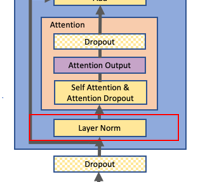

GPT에서 Layer Normalization은 벡터들의 값을 정규화하여 training 시간을 줄이는 것이 목표!

In [ ]:
layer_norm = nn.LayerNorm(hidden_size, eps = 1e-5)
ln_vector = layer_norm(final_embed_vector)

4. Masked Multi-Head Self Attention <br>
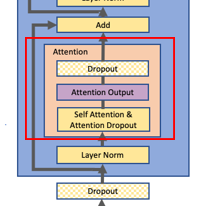
- Masked : 현재 시점 이후의 token을 가림으로써 학습에 참여시키지 않는 것
- Multi : Attention이 2개 이상

In [ ]:
import math
import torch
import torch.nn as nn
from typing import Optional, Tuple

class AttentionLayer(nn.Module):
    def __init__(self, heads : int, dims : int, dropout : float = 0.1):
        super().__init__()
        self.attn = MultiHeadAttention(heads, dropout)
        self.proj_q = nn.Linear(dims, dims) # (h, h)
        self.proj_k = nn.Linear(dims, dims) # (h, h)
        self.proj_v = nn.Linear(dims, dims) # (h, h)
        self.linear = nn.Linear(dims, dims) # (h, h)

    def forward(self,
                q: torch.Tensor,
                k: torch.Tensor,
                v: torch.Tensor,
                past: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,
                mask: Optional[torch.Tensor] = None
                ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        
        # Get Query, Key, Value / Shape : (batch_size, seq_length, hidden_size)
        q, k, v = self.proj_q(q), self.proj_k(k), self.proj_v(v)
 
        s = self.attn(q, k, v, mask)
        x = self.linear(s)  # (h, h)
 
        return x, (k, v)

5. forward 함수 <br>
- q, k, v : 들어온 input tensor로 Query, Key, Value를 만드는 것 <br>
실제로 GPT가 Pre-training될 때 학습되는 것은 Q, K, V를 만드는 Layer이다. <br>
들어온 input tensor가 (batch_size, seq_length, hidden_size)의 shape을 가지기 때문에 Query, Key, Value 모두 같은 shape을 가진다.<br>
즉, 각 토큰이 모두 Query, Key, Value를 갖는다. <br>

- s : Multi-Head Attention을 거치는 것 <br>
Multi-Head Attention이란 한 개의 Query, Key, Value를 여러개로 쪼개는 것

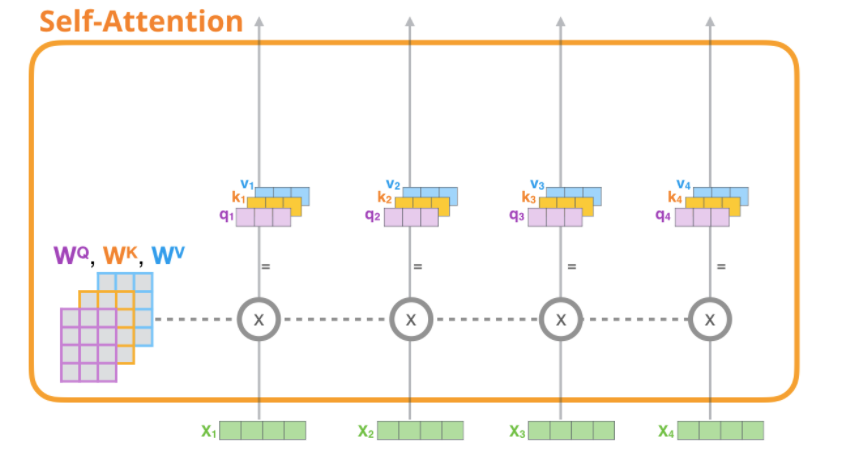

In [1]:
import math
import torch
import torch.nn as nn
from typing import Optional, Tuple

class MultiHeadAttention(object):
    def __init__(self, heads: int, dropout: float = 0.1):
        super().__init__(dropout)
        self.heads = heads
        self.dropout = nn.Dropout(dropout)

    def forward(self,
                q : torch.Tensor,
                k : torch.Tensor,
                v : torch.Tensor,
                mask : Optional[torch.Tensor] = None) -> torch.Tensor:
        
        # split the tensors to multi-heads
        # shape : (batch_size, seq_length, head_num, one_head_len)
        q = q.view(q.size()[:-1] + (self.heads, q.size(-1) // self.heads))
        k = k.view(k.size()[:-1] + (self.heads, k.size(-1) // self.heads))
        v = v.view(v.size()[:-1] + (self.heads, v.size(-1) // self.heads))

        # shape : (batch_size, head_num, seq_length, one_head_len)
        q = q.transpose(-3, -2)
        k = k.transpose(-3, -2)
        v = v.transpose(-3, -2)

        if mask is not None:
            mask = mask.unsqueeze(-3) # (batch_size, 1, seq_length, seq_length)
            mask = mask.type_as(x) # (batch_size, head_num, seq_length, seq_length)

        # calculate multi-headed attentions and merge them into one
        k = k.transpose(-2, -1) # (batch_size, head_num, one_head_len, seq_length)
        num_heads_sqrt = math.sqrt(k.size(-1)) # sqrt(head_num)

        # matrix Multiple Query AND Keys / Divide with sqrt(head_num)
        # shape : (batch_size, head_num, seq_length, seq_length)
        masked_score = score + mask * score.new_tensor(-1e6)

        # softmax
        # float that large negative number has added becomes to zero
        masked_score = masked_score.softmax(-1)
        masked_score = self.dropout(masked_score)

        # matrix Multiple score and value
        # shape : (batch_size, head_num, seq_length, one_head_len)
        attention_score = torch.matmul(x, v)

        # (batch_size, seq_length, head_num, one_head_len)
        attention_score = attention_score.transpose(-3, -2).contiguous()

        # (batch_size, seq_length, hidden_size)
        original_shape = q.size()[:-3] + (q.size(-2), v.size(-1) * self.heads)
        attention_score = attention_score.view(original_shape)

        return attention_score